In [1]:
import os
import numpy as np
import math
import xarray as xr
from src.hls_funcs.masks import mask_hls
from rasterio.plot import show
from matplotlib import colors
import re

In [2]:
atsa_params = {
    'dn_max': 10000,  # maximum value of DN, e.g. 7-bit data is 127, 8-bit is 255
    'background': -999,  # DN value of background or missing values, such as SLC-off gaps
    'buffer': 5,  # width of buffer applied to detected cloud and shadow, recommend 1 or 2
    # parameters for HOT calculation and cloud detection
    'n_image': 107,  # number of images in the time-series
    'n_band': 5,   # number of bands of each image
    'blue_b': 1,  # band index of blue band, note: MSS does not have blue, use green as blue
    'green_b': 2,  # band index of green band
    'red_b': 3,  # band index of red band
    'nir_b': 4,  # band index of nir band
    'swir_b': 5,  # band index of swir band
    'A_cloud': 1.2,  # threshold to identify cloud (mean+A_cloud*sd), recommend 0.5-1.5, smaller values can detect thinner clouds
    # parameters for shadow detection
    'shortest_d': 0.0,  # shortest distance between shadow and cloud, unit is pixel resolution (default 7.0)
    'longest_d': 134.0, # longest distance between shadow and its corresponding cloud, unit is "pixel",can be set empirically by inspecting images
    'B_shadow': 1.0,  # threshold to identify shadow (mean-B_shadow*sd), recommend 1-3, smaller values can detect lighter shadows (default 1.5)
}

atsa_params['maxblue_clearland'] = atsa_params['dn_max'] * 0.15  # estimated maximum blue band value for clear land surface
atsa_params['maxnir_clearwater'] = atsa_params['dn_max'] * 0.05  # estimated maximum nir band value for clear water surface'

In [3]:
cmap_mask = colors.ListedColormap(['black', 'green', 'red', 'blue'])
boundaries = [0, 0.5, 1.5, 2.5, 3.5]
norm_mask = colors.BoundaryNorm(boundaries, cmap_mask.N, clip=True)

In [4]:
import glob
yr=2022
prefix = 'cper'

#outDIR = os.path.join('/90daydata/cper_neon_aop/hls_nrt', prefix)
outDIR = os.path.join('data/hls_nrt/', prefix)

In [5]:
clust_loc = 'local'

In [6]:
if clust_loc == 'local':
    from dask.distributed import LocalCluster, Client
    import dask
    cluster = LocalCluster(n_workers=8, threads_per_worker=2)
    client = Client(cluster)
elif clust_loc == 'hpc':
    from dask.distributed import LocalCluster, Client
    import dask_jobqueue as jq
    import dask
    from jupyter_server import serverapp
    # get server base url
    try:
        jupServer = [x for x in serverapp.list_running_servers()][0]
    except IndexError:
        # import manually if needed
        jupServer = {'base_url': '/node/ceres20-compute-53-eth.scinet.local/53953/'}
    print('   setting up cluster on HPC...')
    dask.config.set({'distributed.dashboard.link': jupServer['base_url'] + 'proxy/{port}/status'})
    partition='short',#'short','debug', 'mem', 'mem-low',
    num_processes = 4
    num_threads_per_processes = 2
    mem = 5*num_processes*num_threads_per_processes
    n_cores_per_job = num_processes*num_threads_per_processes
    clust = jq.SLURMCluster(queue=partition,
                            processes=num_processes,
                            cores=n_cores_per_job,
                            memory=str(mem)+'GB',
                            interface='ib0',
                            #interface='enp24s0f0',
                            local_directory='$TMPDIR',
                            death_timeout=30,
                            walltime='02:00:00',
                            job_extra=["--output=/dev/null","--error=/dev/null"])
    client=Client(clust)
    #Scale Cluster 
    num_jobs=8
    clust.scale(jobs=num_jobs)
    try:
        client.wait_for_workers(n_workers=num_jobs*num_processes, timeout=60)
    except dask.distributed.TimeoutError as e:
        print(str(num_jobs*num_processes) + ' workers not available. Continuing with available workers.')
        #print(e)
        pass

display(client)

2022-06-27 18:12:35,092 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/dask-worker-space/worker-41skew27', purging
2022-06-27 18:12:35,122 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/dask-worker-space/worker-aa_6go50', purging
2022-06-27 18:12:35,161 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/dask-worker-space/worker-bf7u5wv4', purging
2022-06-27 18:12:35,196 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/dask-worker-space/worker-fbnxu_d3', purging
2022-06-27 18:12:35,221 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/dask-worker-space/worker-g6hqvplr', purging
2022-06-27 18:12:35,247 - distributed.diskutils - INFO - Found stale lock file and directory '/

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 15.49 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39307,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 15.49 GiB
Comm: tcp://127.0.0.1:39885,Total threads: 2
Dashboard: http://127.0.0.1:36417/status,Memory: 1.94 GiB
Nanny: tcp://127.0.0.1:35055,


In [7]:
nc_flist = list(filter(os.path.isfile, 
                    glob.glob(os.path.join(outDIR,
                              prefix + 
                              '_hls_tmp/' + 'hls_ds_' + str(yr) + '*.nc'))))
if len(nc_flist) > 0:
    nc_flist.sort(key=lambda x: os.path.getctime(x))
    nc_f = nc_flist[-1]
else:
    print('ERROR: No temp nc file found')

hls_ds = xr.open_dataset(nc_f)

hls_ds = hls_ds.chunk({'time': 1, 'y': -1, 'x': -1})

In [8]:
hls_ds = hls_ds.where(~hls_ds['NIR1'].isnull().all(dim=['y', 'x']), drop=True)
snow =  mask_hls(hls_ds['FMASK'], mask_types=['snow'])
hls_ds = hls_ds.where(~(snow==1).all(dim=['y', 'x']), drop=True)
hls_ds[['BLUE', 'GREEN', 'RED', 'NIR1', 'SWIR1', 'SWIR2']] = hls_ds[['BLUE', 'GREEN', 'RED', 'NIR1', 'SWIR1', 'SWIR2']].where(snow == 0)

water = mask_hls(hls_ds['FMASK'], mask_types=['water']).all(dim='time')
cloud = mask_hls(hls_ds['FMASK'], mask_types=['cloud', 'cirrus', 'cloud_adj'])
hls_mask = mask_hls(hls_ds['FMASK'], mask_types=['all'])

In [9]:
hls_ds

<xarray.Dataset>
Dimensions:      (time: 77, y: 323, x: 323)
Coordinates:
  * time         (time) datetime64[ns] 2021-11-03 2021-11-04 ... 2022-06-25
  * x            (x) float64 5.176e+05 5.176e+05 ... 5.272e+05 5.272e+05
  * y            (y) float64 4.524e+06 4.524e+06 ... 4.515e+06 4.515e+06
Data variables:
    BLUE         (time, y, x) float64 dask.array<chunksize=(1, 323, 323), meta=np.ndarray>
    GREEN        (time, y, x) float64 dask.array<chunksize=(1, 323, 323), meta=np.ndarray>
    RED          (time, y, x) float64 dask.array<chunksize=(1, 323, 323), meta=np.ndarray>
    NIR1         (time, y, x) float64 dask.array<chunksize=(1, 323, 323), meta=np.ndarray>
    SWIR1        (time, y, x) float64 dask.array<chunksize=(1, 323, 323), meta=np.ndarray>
    SWIR2        (time, y, x) float64 dask.array<chunksize=(1, 323, 323), meta=np.ndarray>
    FMASK        (time, y, x) float64 dask.array<chunksize=(1, 323, 323), meta=np.ndarray>
    SZA          (time, y, x) float64 dask.array<chunksize=(1, 323, 323), meta=np.ndarray>
    SAA          (time, y, x) float64 dask.array<chunksize=(1, 323, 323), meta=np.ndarray>
    VZA          (time, y, x) float64 dask.array<chunksize=(1, 323, 323), meta=np.ndarray>
    VAA          (time, y, x) float64 dask.array<chunksize=(1, 323, 323), meta=np.ndarray>
    maskcov_pct  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    crs:         epsg:32613
    transform:   [ 3.00000e+01  0.00000e+00  5.17590e+05  0.00000e+00 -3.0000...
    resolution:  30

In [10]:
#hls_ds = hls_ds.drop('maskcov_pct')

In [11]:
# HOT for land surface
ind_l = np.logical_and(np.logical_or(water == 0, hls_ds['NIR1'] >= atsa_params['dn_max']*0.1),
                       hls_mask == 0)
num_l = ind_l.sum(dim=['y', 'x'])

rmin0 = 0.01 * atsa_params['dn_max']  # min DN value of blue band for computing clear line
rmax = atsa_params['maxblue_clearland']  # max DN value of blue band for computing clear line
num_valid = np.logical_and(hls_ds['BLUE'].where(num_l > 0) >= rmin0,
                           hls_ds['BLUE'].where(num_l > 0) <= rmax).sum(dim=['y', 'x'])

rmin = hls_ds['BLUE'].where(num_valid > 0).min(dim=['y', 'x']).compute()

n_bin = 50

/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keep

In [12]:
import pandas as pd
import statsmodels.formula.api as smf

def calc_hot(da_blue, da_red, rmin, rmax, n_bin):
    def calc_hot_np(x, y):
        ind_0 = x > 0
        num_sample = np.sum(ind_0)
        x = x[ind_0]
        y = y[ind_0]
        x = pd.Series(x)
        y = pd.Series(y)
        fitdata = pd.DataFrame()
        fitdata['x'] = x
        fitdata['y'] = y
        if num_sample >= 0.5 * n_bin:
            # compute slope of clear line
            mod = smf.quantreg('y ~ x', fitdata)
            result = mod.fit(q=.5, max_iter=5000)

            result1 = result.params.x
            result0 = result.params.Intercept
            slop = result.params.x
            intercept = result.params.Intercept
            if result.params.x <= 1.5:
                result1 = 1.5
                result0 = np.mean(y) - result1 * np.mean(x)
                slop = 0
                intercept = 0
        else:
            result1 = 1.5
            result0 = np.mean(y) - 1.5 * np.mean(x)
            slop = 0
            intercept = 0
        return result0, result1, slop, intercept
    
    def calc_hot_xr(da_x, da_y):
        ds_out = xr.apply_ufunc(calc_hot_np,
                                *[da_x, da_y],
                                dask='parallelized',
                                vectorize=True,
                                input_core_dims=[['bin_min'], ['bin_min']],
                                output_core_dims=[[], [], [], []],
                                output_dtypes=[float, float, float, float])
        return ds_out
    
    def argsort_xr(dat_stacked):
        sort_stacked = xr.apply_ufunc(np.argsort,
                              dat_stacked,
                              dask='parallelized',
                              vectorize=True,
                              input_core_dims=[['bin_min']],
                                     output_core_dims=[['bin_min']],
                                    output_dtypes=[int])
        return sort_stacked.unstack('z')
    
    bin_size = (rmax - rmin) / float(n_bin)
    bin_size = bin_size.expand_dims(dim={'bin_min': np.arange(0, n_bin)})
    bin_size = bin_size.chunk({'time': 1, 'bin_min': -1})

    ind_bin = np.logical_and(da_blue >= rmin + bin_size.bin_min * bin_size,
                             da_blue < rmin + (bin_size.bin_min + 1) * bin_size)
    num_bin = ind_bin.sum(['y', 'x'])#.compute()

    x_bin = da_blue.where(num_bin >= 20)

    x_bin = da_blue.where(num_bin >= 20)#.compute()
    y_bin = da_red.where(num_bin >= 20)#.compute()

    ind_good = (y_bin <= y_bin.mean(dim=['y', 'x']) + 3.0 * y_bin.std(dim=['y', 'x']))
    num_good = ind_good.sum(dim=['y', 'x'])#.compute()

    x_bin = x_bin.where(ind_good)#.compute()
    y_bin = y_bin.where(ind_good)#.compute()
    order = argsort_xr(y_bin.stack(z=['y', 'x']))

    top_num = np.ceil(0.01 * num_good)
    top_num = top_num.where(top_num < 20, 20)#.compute()

    x_bin_select = x_bin.where(np.logical_and(order >= (num_good - top_num),
                                              order <= num_good))#.compute()
    y_bin_select = y_bin.where(np.logical_and(order >= (num_good - top_num),
                                              order <= num_good))#.compute()

    x_bin_select = x_bin_select.transpose('time', 'bin_min', 'y', 'x')
    y_bin_select = y_bin_select.transpose('time', 'bin_min', 'y', 'x')

    x_hot = x_bin_select.groupby('time').mean(['y', 'x'])#.chunk({'time': 1, 'bin_min': -1})
    y_hot = y_bin_select.groupby('time').mean(['y', 'x'])#.chunk({'time': 1, 'bin_min': -1})

    #x_hot.compute()

    ds_hot = xr.concat(calc_hot_xr(x_hot, y_hot), dim='var')
    ds_hot = ds_hot.assign_coords(var=['result0', 'result1', 'slope', 'intercept'])
    ds_hot = ds_hot.to_dataset(dim='var')
    return ds_hot

In [13]:
"""
Calculate HOT as Cloud Index and create initial mask
"""

# get parameters to calculate HOT image
#hot_params = calc_hot(x_hot, y_hot)
#hls_ds = hls_ds.chunk({'time': 1, 'y': 10, 'x': 10})
hot_params = calc_hot(hls_ds['BLUE'].where(ind_l), hls_ds['RED'].where(ind_l), rmin, rmax, n_bin).persist()

In [14]:
# calculate HOT image from parameters
hot_img = abs(hls_ds['BLUE'] * hot_params['result1'] - 
              hls_ds['RED'] + hot_params['result0']) / (1.0 + hot_params['result1'] ** 2) ** 0.5


# find images totally covered by clouds or unreasonable clear-sky line
ind_t = (hot_params['slope'] == 0).values
num_t = np.sum(ind_t)
if num_t < len(hot_params.time):
    mean_slop = np.mean(hot_params['slope'].where(hot_params['slope'] != 0))
    mean_int = np.mean(hot_params['intercept'].where(hot_params['intercept'] != 0))
else:
    mean_slop = 1.5  # for extreme case: no image can get valid clear_sky line
    mean_int = 0

if num_t > 0:  # use average slope for those totally covered images
    da_blue = hls_ds['BLUE']
    da_red = hls_ds['RED']
    hot_img = xr.where(hot_img.where(hot_img['time'].isin(hot_img['time'][ind_t])),
                       np.abs(da_blue * mean_slop - da_red + mean_int) / (1.0 + mean_slop ** 2) ** 0.5,
                       hot_img)

# for water surface
ind_w = np.logical_and(
    np.logical_and(water == 1, hls_ds['NIR1'] < atsa_params['dn_max'] * 0.1), 
    hls_ds['NIR1'].notnull())
num_w = ind_w.sum(dim=['y', 'x'])
da_nir = hls_ds['NIR1'].where(ind_w)
da_blue = hls_ds['BLUE'].where(ind_w)
rminw = xr.where(da_nir.min(dim=['y', 'x']) < 0, 0, da_nir.min(dim=['y', 'x']))
rmaxw = rminw + atsa_params['maxnir_clearwater']
n_binw = 30

ind_valid = np.logical_and(da_nir >= rminw, da_nir <= rmaxw)
num_valid = ind_valid.sum(dim=['y', 'x'])
if (num_valid > 0).any():
    if (num_valid > 500).any():
        hot_params_w = calc_hot(hls_ds['NIR1'].where(ind_w ), hls_ds['BLUE'].where(ind_w), rminw, rmaxw, n_binw)
        hot_img_w = abs(hls_ds['NIR1'].where(ind_w) * hot_params['result1'] - 
              hls_ds['BLUE'].where(ind_w) + hot_params['result0']) / (1.0 + hot_params['result1'] ** 2) ** 0.5
        hot_img = xr.where(ind_w, hot_img_w, hot_img)
    else:
        # if all/most water are covered by clouds, compute HOT for land and water together
        hot_img = xr.where(hot_img.where(hot_img['time'].isin(hot_img['time'][num_w > 0])),
                           np.abs(da_blue * mean_slop - da_red + mean_int) / (1.0 + mean_slop ** 2) ** 0.5,
                           hot_img)

/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/py

In [15]:
# create mask array and exclude background and missing gaps: these pixels marked as mask=3 and HOT=0
mask = xr.where(hot_img.isnull(), 3, xr.ones_like(hot_img))
hot_img = hot_img.fillna(0).persist()

<xarray.DataArray (time: 77, y: 323, x: 323)>
dask.array<where, shape=(77, 323, 323), dtype=float64, chunksize=(1, 323, 323), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2021-11-03 2021-11-04 ... 2022-06-25
  * x        (x) float64 5.176e+05 5.176e+05 5.176e+05 ... 5.272e+05 5.272e+05
  * y        (y) float64 4.524e+06 4.524e+06 4.524e+06 ... 4.515e+06 4.515e+06

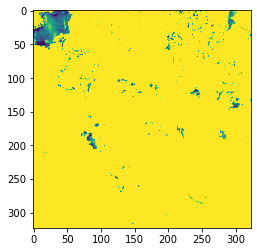

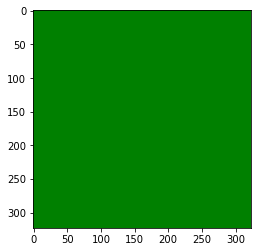

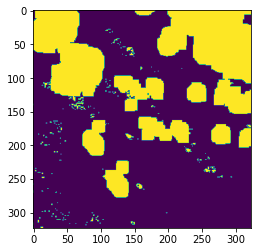

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


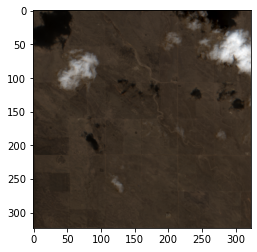

<AxesSubplot:>

In [16]:
display(hot_img)
t=43
show(hot_img.isel(time=t).values, vmin=10, vmax=100)
show(mask.isel(time=t).values, cmap=cmap_mask, norm=norm_mask)
show(hls_mask.isel(time=t).values, vmin=0, vmax=1)

show([hls_ds.isel(time=t)['RED'].values/hls_ds.isel(time=t)['RED'].max().values,
     hls_ds.isel(time=t)['GREEN'].values/hls_ds.isel(time=t)['GREEN'].max().values,
     hls_ds.isel(time=t)['BLUE'].values/hls_ds.isel(time=t)['BLUE'].max().values])

In [17]:
from sklearn.cluster import KMeans
import numpy as np
import xarray as xr
from skimage.morphology import remove_small_objects

def classify_cloud(surf_type, type_p, HOT, mask, water, cloud, prop_cloud=0.5):
    """
    use K-means clustering to classify cloud pixels into 3 classes
    Args:
        surf_type: 'land' or 'water'
        type_p: land surface or water surface in cloud mask
        HOT: HOT used for selecting samples
        mask: initial cloud mask
        water: the input water mask (water == 1)
        cloud: the input cloud mask (cloud == 1)
        prop_cloud: the proportion of cloudy pixels to include in the sample for k-means
    return:
        center_class: HOT centers of clear, thin and thick cloudy pixels on land or water
        mask: the computed cloud mask with value 0: shadow 1: clear pixels 2: clouds 3: background or missing pixels
        
    NOTE: Adapted from Zhu et al. 2018 to include a proprotion of sample pixels to be known clouds. This was important to
    fix commission error from bare ground pixels and readily implemented from the HLS FMASK
    """
    
    num_cluster = 3
    n_sample_kmean = 10000.0
    n_sample_cloud = int(n_sample_kmean*prop_cloud)
    n_sample_clear = n_sample_kmean - n_sample_cloud
    cloud_hot = hot_img.where(np.logical_and(cloud==1, type_p)).values.flatten()
    clear_hot = hot_img.where(np.logical_and(cloud!=1, type_p)).values.flatten()
    cloud_hot = cloud_hot[~np.isnan(cloud_hot)]
    clear_hot = clear_hot[~np.isnan(clear_hot)]
    inter_sample_cloud = np.floor(len(cloud_hot)/n_sample_cloud)
    index_sample_cloud = (np.arange(n_sample_cloud)).astype(int)*int(inter_sample_cloud)  # get systematic sample of indices
    sample_cloud = cloud_hot[index_sample_cloud]
    inter_sample_clear = np.floor(len(clear_hot)/n_sample_clear)
    index_sample_clear = (np.arange(n_sample_clear)).astype(int)*int(inter_sample_clear)  # get systematic sample of indices
    sample_clear = clear_hot[index_sample_clear]
    sample_kmean = np.concatenate([sample_cloud, sample_clear])
    center_class = KMeans(n_clusters=num_cluster, n_init=50, random_state=0).fit(sample_cloud.reshape(-1, 1))
    center_class = np.sort((center_class.cluster_centers_).ravel())
    print("HOT centers of clear, thin and thick cloudy pixels on", surf_type, ':', center_class)
    if surf_type == 'land':
        ind_type = np.logical_and(mask != 3, water == 0)
    elif surf_type == 'water':
        ind_type = np.logical_and(mask != 3, water == 1)
    cloud_i = HOT.where(ind_type)
    dis_c1 = abs(cloud_i - center_class[0])
    dis_c2 = abs(cloud_i - center_class[1])
    newmask = mask * ~ind_type
    newmask = newmask + (((dis_c1 >= dis_c2).astype(int)) + 1) * ind_type

    return center_class[0], center_class[1], newmask
    
def remove_cloud(method, mask, iters=5):
    """
    remove isolated cloud pixels
    Args:
        method: 1: remove isolated cloud pixels in initial cloud mask  
                2: remove isolated cloud pixels by an iterative process
                3: remove using a size threshold
        mask: the most recently updated mask
    return:
        newmask: the updated mask after removing isolated cloud pixels
    """
    if method == 1:
        # get pixels where value is cloud (mask == 2)
        cloud_pix = mask == 2
        # get isolated cloud pixels, where less than 1/4 of 4x4 window are also clouds
        cloud_sum = cloud_pix.rolling({'y':4, 'x':4}).sum() <= 4
        # remove isolated cloud pixels
        newmask = xr.where(cloud_pix & cloud_sum, 1, mask)
    if method == 2:
        diff = 1000
        itime = 0
        newmask = mask.copy()
        while diff >= iters >= itime:
            print(diff)
            # get pixels where value is cloud (mask == 2)
            cloud_pix = newmask == 2
            # get isolated cloud pixels, where less than 1/4 of 4x4 window are also clouds
            cloud_sum = cloud_pix.rolling({'y':4, 'x':4}).sum() <= 4
            # remove isolated cloud pixels
            newmask = xr.where(cloud_pix & cloud_sum, 1, mask)
            # get the max difference between the new and original mask across each date
            diff = (abs(newmask - mask)).sum(dim=['y', 'x']).max().values
            itime = itime + 1
    if method == 3:
        newmask = mask.copy()
        cloud_pix = newmask == 2
        # get isolated cloud pixels not surrounded by other cloud pixels, where less than 1/2 of 4x4 window are also clouds
        cloud_sum = cloud_pix.rolling({'y':4, 'x':4}).sum() <= 8
        newcloud_pix = xr.apply_ufunc(remove_small_objects,
                                      cloud_pix,
                                      kwargs={'min_size': 8},
                                      dask='parallelized',
                                      vectorize=True,
                                      input_core_dims=[['y', 'x']],
                                      output_core_dims=[['y', 'x']])
        newmask = xr.where((newcloud_pix == 0) & cloud_sum & cloud_pix, 1, mask)
    return newmask    

def buffer_cloud(mask, buffern):
    """
    buffer all could pixels to further reduce omission errors around edges
    Args:
        mask: the computed mask from last step
        buffern: the buffer size of cloud patches, in pixels
    return:
        newmask: the updated cloud mask (cloud == 2), with clouds buffered by buffern pixels
    """
    cloud = mask == 2
    cloud_buff = cloud.rolling({'y': buffern+1, 'x': buffern+1}).sum() > 0
    newmask = xr.where(cloud_buff, 2, mask)
    return newmask

In [18]:
"""
Get initial mask from K-means classification
"""
land_cloud_p = np.logical_and(mask != 3, water == 0)
kmeansresult = classify_cloud(surf_type='land', type_p=land_cloud_p, HOT=hot_img, mask=mask, water=water, cloud=cloud)
center_class = kmeansresult[0:2]
mask = kmeansresult[2].persist()

Th_initial = np.zeros(2).astype(float)
Th_initial[1] = (center_class[0] + center_class[1]) / 2.0

mask = remove_cloud(1, mask)

HOT centers of clear, thin and thick cloudy pixels on land : [ 211.0847653   815.79823681 1849.89715526]


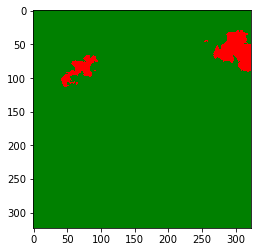

<AxesSubplot:>

In [19]:
show(mask.isel(time=t).values, cmap=cmap_mask, norm=norm_mask)

In [20]:
"""
Detect thin cloud and remove isolated cloud pixels
"""
# a global threshold for detect cloud in a time series with clear points < 2
meanv = hot_img.where(mask==2).mean().values
sdv = hot_img.where(mask==2).std().values
g_th = meanv - 1.0 * sdv

In [21]:
# judge cloud using samples where fewer than 2 dates are clouds to compute the mean and sd
ind_valid = np.logical_and(mask != 2, mask != 3).sum('time') >= 2
b2_mean = hot_img.where(ind_valid).mean().values
b2_sd = hot_img.where(ind_valid).std().values
Th_initial_xr = xr.where(water==0, Th_initial[1], Th_initial[0])
b2_range = hot_img.where(ind_valid).max().values - hot_img.where(ind_valid).min().values

In [22]:
adjust_T = (Th_initial_xr - b2_range) / (Th_initial_xr + b2_range)
# refine initial cloud
ind_ini_cloud = np.logical_and(hot_img <= b2_mean + (adjust_T + atsa_params['A_cloud']) * b2_sd, mask == 2)
num_miss_cloud = ind_ini_cloud.sum(dim='time')
mask = xr.where(np.logical_and(
    np.logical_and(
        ind_ini_cloud, num_miss_cloud > 0), ind_valid),
                1, mask)

# Add missed clouds
ind_cloud = np.logical_and(np.logical_and(hot_img > b2_mean + (adjust_T + atsa_params['A_cloud']) * b2_sd,
                                          hls_ds['NIR1'] > atsa_params['dn_max'] * 0.1), mask != 3)
num_cloud = ind_cloud.sum(dim='time')
mask = xr.where(np.logical_and(
    np.logical_and(
        ind_cloud, num_cloud > 0), ind_valid),
                2, mask)

ind_cloud_lt2 = np.logical_and(hot_img > g_th, mask != 3)
num_cloud_lt2 = ind_cloud_lt2.sum(dim='time')
mask = xr.where(np.logical_and(
    np.logical_and(
        ind_cloud_lt2, num_cloud_lt2 > 0), ~ind_valid),
                2, mask)

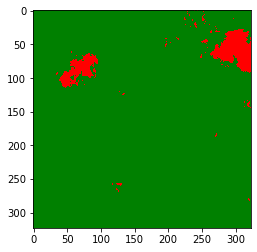

<AxesSubplot:>

In [23]:
show(mask.isel(time=t).values, cmap=cmap_mask, norm=norm_mask)

In [24]:
# remove isolate cloud pixels by an iterative process
mask = remove_cloud(3, mask)
# buffer cloud by a window

In [25]:
mask = buffer_cloud(mask, atsa_params['buffer']).persist()

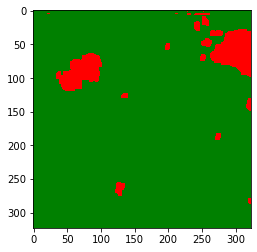

<AxesSubplot:>

In [26]:
show(mask.isel(time=t).values, cmap=cmap_mask, norm=norm_mask)

### Detect shadows - Estimate potential shadows

In [27]:

# prep sun angle data
#da_za = ((hls_ds['SZA'].mean(dim=['y', 'x'])*0.01) / 180.0) * math.pi
#da_aa = (hls_ds['SAA'].mean(dim=['y', 'x'])*0.01 / 180.0) * math.pi

#da_za = da_za.where(~hls_ds['SZA'].isnull().all(dim=['y', 'x']))
#da_aa = da_aa.where(~hls_ds['SZA'].isnull().all(dim=['y', 'x']))

# make sure longest distance (in pixels) is not more that the width/length of the scene
longest_d = min([atsa_params['longest_d'], hls_ds.x.size, hls_ds.y.size])
shortest_d = atsa_params['shortest_d']


#height = h_low + np.arange(num_int) * 3.0

In [28]:
def shadow_zone(sun_za, sun_aa, v_za, v_aa, longest_d, shortest_d, mask, data):
    
    def np_shadow_zone(num_int_i, h_low_i, mask_arr, nl, ns, sun_za_i, sun_aa_i, v_za_i, v_aa_i):
        shadow_img_arr = np.zeros((nl, ns)).astype(bytearray)
        shadow_edge_arr = np.zeros((nl, ns)).astype(bytearray)
        if not np.isnan(num_int_i):
            height_arr = h_low_i + np.arange(num_int_i) * 3.0
            end_x1_i = int(np.round(
                -height_arr[int(num_int_i) - 1] * np.tan(sun_za_i) * np.sin(sun_aa_i)) + \
                          np.round(height_arr[int(num_int_i) - 1] * np.tan(v_za_i) * np.sin(v_aa_i)))
            end_y1_i = int(np.round(
                height_arr[int(num_int_i) - 1] * np.tan(sun_za_i) * np.cos(sun_aa_i)) + \
                          np.round(height_arr[int(num_int_i) - 1] * np.tan(v_za_i) * np.cos(v_aa_i)))
            
            # there are four cases for the shadow shifting from clouds:
            mask0 = mask_arr.copy()
            for ih in range(0, int(num_int_i)):
                shift_x1 = np.round(-height_arr[ih] * np.tan(sun_za_i) * np.sin(sun_aa_i)) + \
                np.round(height_arr[ih] * np.tan(v_za_i) * np.sin(v_aa_i))
                shift_y1 = np.round(height_arr[ih] * np.tan(sun_za_i) * np.cos(sun_aa_i)) + \
                np.round(height_arr[ih] * np.tan(v_za_i) * np.cos(v_aa_i))
                shift_x1 = int(shift_x1)
                shift_y1 = int(shift_y1)
                mask_last = mask0.copy()
                if end_x1_i <= 0 and end_y1_i <= 0:
                    mask0[0:nl + shift_y1, 0:ns + shift_x1] = mask_arr[-shift_y1:nl, -shift_x1:ns].copy()
                    shadow_img_arr[:, :] = (
                        np.logical_or(np.logical_or(mask0 == 2, mask_last == 2), shadow_img_arr[:, :] == 1)).astype(int)
                elif end_x1_i <= 0 < end_y1_i:
                    mask0[shift_y1:nl, 0:ns + shift_x1] = mask_arr[0:nl - shift_y1, -shift_x1:ns].copy()
                    shadow_img_arr[:, :] = (
                        np.logical_or(np.logical_or(mask0 == 2, mask_last == 2), shadow_img_arr[:, :] == 1)).astype(int)
                elif end_x1_i > 0 >= end_y1_i:
                    mask0[0:nl + shift_y1, shift_x1:ns] = mask_arr[-shift_y1:nl, 0:ns - shift_x1].copy()
                    shadow_img_arr[:, :] = (
                        np.logical_or(np.logical_or(mask0 == 2, mask_last == 2), shadow_img_arr[:, :] == 1)).astype(int)
                elif end_x1_i > 0 and end_y1_i > 0:
                    mask0[shift_y1:nl, shift_x1:ns] = mask_arr[0:nl - shift_y1, 0:ns - shift_x1].copy()
                    shadow_img_arr[:, :] = (
                        np.logical_or(np.logical_or(mask0 == 2, mask_last == 2), shadow_img_arr[:, :] == 1)).astype(int)
            # for edge: 4 cases
            if end_x1_i <= 0 and end_y1_i <= 0:
                shadow_edge_arr[:, ns - 1 + end_x1_i:ns] = 99
                shadow_edge_arr[nl - 1 + end_y1_i:nl, :] = 99
            elif end_x1_i <= 0 < end_y1_i:
                shadow_edge_arr[:, ns - 1 + end_x1_i:ns] = 99
                shadow_edge_arr[0:end_y1_i + 1, :] = 99
            elif end_x1_i > 0 >= end_y1_i:
                shadow_edge_arr[:, 0:end_x1_i + 1] = 99
                shadow_edge_arr[nl - 1 + end_y1_i:nl, :] = 99
            elif end_x1_i > 0 and end_y1_i > 0:
                shadow_edge_arr[:, 0:end_x1_i + 1] = 99
                shadow_edge_arr[0:end_y1_i + 1, :] = 99
        return shadow_img_arr, shadow_edge_arr
    
    shadow_imgs = []
    shadow_edges = []
    
    for iy in [0, -1]:
        for ix in [0, -1]:
            
            sun_za_i = sun_za.isel(y=iy, x=ix)
            sun_aa_i = sun_aa.isel(y=iy, x=ix)
            v_za_i = v_za.isel(y=iy, x=ix)
            v_aa_i = v_aa.isel(y=iy, x=ix)
                    
            h_high = longest_d / (
                    ((np.tan(sun_za_i) * np.sin(sun_aa_i)) ** 2 + (np.tan(sun_za_i) * np.cos(sun_aa_i)) ** 2) ** 0.5)

            h_low = shortest_d / (
                            ((np.tan(sun_za_i) * np.sin(sun_aa_i)) ** 2 + (np.tan(sun_za_i) * np.cos(sun_aa_i)) ** 2) ** 0.5)

            num_int = (np.ceil((h_high - h_low) / 3.0)).where(~sun_za_i.isnull()).astype('int')
            
            shadow_img_xr_i = xr.apply_ufunc(np_shadow_zone,
                                             num_int,
                                             h_low,
                                             mask,
                                             data.y.size,
                                             data.x.size,
                                             sun_za_i,
                                             sun_aa_i,
                                             v_za_i,
                                             v_aa_i,
                                             dask='parallelized',
                                             vectorize=True,
                                             input_core_dims=[[], [], ['y', 'x'], [], [], [], [], [], []],
                                             output_core_dims=[['y', 'x'], ['y', 'x']],
                                             output_dtypes=['int', 'int'])
            shadow_imgs.append(shadow_img_xr_i[0])
            shadow_edges.append(shadow_img_xr_i[1])
        
    shadow_img_xr = xr.concat(shadow_imgs, dim='ixy')
    shadow_edge_xr = xr.concat(shadow_edges, dim='ixy')
    
    return shadow_img_xr.max(dim='ixy'), shadow_edge_xr.max(dim='ixy')  


def classify_shadow(surf_type, type_p, shadow_idx, mask2, water, shadow, prop_shadow=0.5):
    """
    use K-means clustering to classify cloud pixels into 3 classes
    Args:
        surf_type: 'land' or 'water'
        type_p: land surface or water surface in cloud mask
        shadow_idx: shadow index used for selecting samples
        mask2: initial shadow mask
        water: the input water mask (water == 1)
        shadow: the input shadow mask (shadow == 1)
        prop_shadow: the proportion of shadow pixels to include in the sample for k-means
    return:
        center_class: shadow index centers of clear and shadow pixels on land or water
        mask: the computed mask with value 0: shadow 1: clear pixels 2: clouds 3: background or missing pixels
        
    NOTE: Adapted from Zhu et al. 2018 to include a proprotion of sample pixels to be known shadows.
    """
    
    num_cluster = 3
    n_sample_kmean = 10000.0
    n_sample_shadow = int(n_sample_kmean*prop_shadow)
    n_sample_non = n_sample_kmean - n_sample_shadow
    shadow_vals = shadow_idx.where(np.logical_and(shadow==1, type_p)).values.flatten()
    nonshadow_vals = shadow_idx.where(np.logical_and(shadow!=1, type_p)).values.flatten()
    shadow_vals = shadow_vals[~np.isnan(shadow_vals)]
    nonshadow_vals = nonshadow_vals[~np.isnan(nonshadow_vals)]
    inter_sample_shadow = np.floor(len(shadow_vals)/n_sample_shadow)
    index_sample_shadow = (np.arange(n_sample_shadow)).astype(int)*int(inter_sample_shadow)  # get systematic sample of indices
    sample_shadow = shadow_vals[index_sample_shadow]
    inter_sample_non = np.floor(len(nonshadow_vals)/n_sample_non)
    index_sample_non = (np.arange(n_sample_non)).astype(int)*int(inter_sample_non)  # get systematic sample of indices
    sample_non = nonshadow_vals[index_sample_non]
    sample_kmean = np.concatenate([sample_shadow, sample_non])
    center_class = KMeans(n_clusters=num_cluster, n_init=50, random_state=0).fit(sample_shadow.reshape(-1, 1))
    center_class = np.sort((center_class.cluster_centers_).ravel())
    print("Shadow index centers of shadow, nonshadow dark and nonshadow bright on", surf_type, ':', center_class)
    if surf_type == 'land':
        ind_type = np.logical_and(mask2 == 0, water == 0)
    elif surf_type == 'water':
        ind_type = np.logical_and(mask2 == 0, water == 1)
    shadow_i = shadow_idx.where(ind_type)
    dis_c1 = abs(shadow_i - center_class[0])
    dis_c2 = abs(shadow_i - center_class[1])
    newmask = xr.where(ind_type, ((dis_c1 >= dis_c2).astype(int)), mask2)

    return center_class[0], center_class[1], newmask


def buffer_shadow(mask2, buffern, buff_type, value):
    """
    buffer all shadow pixels to further reduce omission errors around edges
    Args:
        mask2: the updated mask
        buffern: the buffer size
        buff_type: 'buffer1': buffer the possible shadow
                   'buffer2': buffer the shadow zone to predict potential zone from IDW
                   'buffer3': buffer shadow to acquire the cloud and shadow mask
        value: the value to update mask2
    return:
        newmask: the updated shadow mask
    """
    if buff_type == 'buffer1':
        shadow = mask2 == 0
        clear = mask2 == 1
        shadow_buff = shadow.rolling({'y': buffern+1, 'x': buffern+1}).sum() > 0
        newmask = xr.where(np.logical_and(clear, shadow_buff), value, mask2)
    elif buff_type == 'buffer2':
        shadow = mask2 == 0
        clear = np.logical_or(mask2 == 1, mask2 == 99)
        shadow_buff = shadow.rolling({'y': buffern+1, 'x': buffern+1}).sum() > 0
        newmask = xr.where(np.logical_and(clear, shadow_buff), value, mask2)
    elif buff_type == 'buffer3':
        shadow = mask2 == 0
        clear = np.logical_and(mask2 != 3, mask2 != 2)
        shadow_buff = shadow.rolling({'y': buffern+1, 'x': buffern+1}).sum() > 0
        newmask = xr.where(np.logical_and(clear, shadow_buff), value, mask2)
    return newmask


def remove_shadow(method, mask, iters=5):
    """
    remove isolated shadow pixels by an iterative process
    Args:
        mask: the most recently updated mask
    return:
        newmask: the updated mask after removing isolated shadow pixels
    """
    if method == 2:
        diff = 1000
        itime = 0
        newmask = mask.copy()
        while diff >= iters >= itime:
            print(diff)
            # get pixels where value is shadow (mask == 0)
            shadow_pix = newmask == 0
            # get isolated cloud pixels, where less than 1/4 of 4x4 window are also clouds
            shadow_sum = shadow_pix.rolling({'y':4, 'x':4}).sum() <= 4
            # remove isolated shadow pixels
            newmask = xr.where(shadow_pix & shadow_sum, 1, mask)
            # get the max difference between the new and original mask across each date
            diff = (abs(newmask - mask)).sum(dim=['y', 'x']).max().values
            itime = itime + 1
    if method == 3:
        newmask = mask.copy()
        shadow_pix = newmask == 0
        # get isolated cloud pixels not surrounded by other cloud pixels, where less than 1/2 of 4x4 window are also clouds
        shadow_sum = shadow_pix.rolling({'y':4, 'x':4}).sum() <= 8
        newshadow_pix = xr.apply_ufunc(remove_small_objects,
                                      shadow_pix,
                                      kwargs={'min_size': 8},
                                      dask='parallelized',
                                      vectorize=True,
                                      input_core_dims=[['y', 'x']],
                                      output_core_dims=[['y', 'x']])
        newmask = xr.where((newshadow_pix == 0) & shadow_sum & shadow_pix, 1, mask)
        
    return newmask    

In [29]:
da_sza = ((hls_ds['SZA']*0.01) / 180.0) * math.pi
da_saa = ((hls_ds['SAA']*0.01) / 180.0) * math.pi

da_vza = ((hls_ds['VZA']*0.01) / 180.0) * math.pi
da_vaa = ((hls_ds['VAA']*0.01) / 180.0) * math.pi

#da_za = da_za.where(~hls_ds['SZA'].isnull().all(dim=['y', 'x']))
#da_aa = da_aa.where(~hls_ds['SZA'].isnull().all(dim=['y', 'x']))

In [30]:
shadow_potn, shadow_edge = shadow_zone(da_sza, da_saa, da_vza, da_vaa, longest_d, shortest_d, mask, hls_ds)

In [31]:
shadow_potn = shadow_potn.astype(int)
shadow_edge = shadow_edge.astype(int)

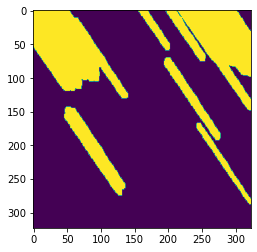

<AxesSubplot:>

In [32]:
show(shadow_potn.isel(time=t))

In [33]:
# overlay possible shadow to cloud mask
mask2 = mask.copy()
ind_shadow_all = np.logical_and(shadow_potn == 1, mask2 == 1)
mask2 = xr.where(ind_shadow_all, 0, mask2)
ind_shadow_edge = np.logical_and(shadow_edge == 99, mask2 == 1)
mask2 = xr.where(ind_shadow_edge, 99, mask2)
# buffer possible shadow by 5*5 window
mask2 = buffer_shadow(mask2, 5, 'buffer1', 0)

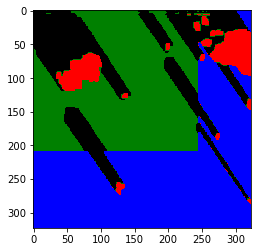

<AxesSubplot:>

In [34]:
show(mask2.isel(time=t), cmap=cmap_mask, norm=norm_mask)

### Detect shadows within potential shadow zones

In [35]:
# compute the proportion of cloud in each image
ind_l = np.logical_and(np.logical_or(water == 0, hls_ds['NIR1'] >= atsa_params['dn_max'] * 0.1), mask2 == 1)
p_clear_land = ind_l.sum(dim=['y', 'x'])

# find first image with least clouds
time_least_cloud = p_clear_land.where(p_clear_land == p_clear_land.max(), drop=True).isel(time=0).time

In [36]:
ind_l = np.logical_and(np.logical_or(water == 0, hls_ds['NIR1'] >= atsa_params['dn_max'] * 0.1), mask <= 1)
num_l = ind_l.sum(dim=['y', 'x'])
ind_comon = np.logical_and(np.logical_and(water == 0, mask2 == 1), mask2.sel(time=time_least_cloud) == 1)
num_comon = ind_comon.sum(dim=['y', 'x'])

In [37]:
# for dates with at least 100 pixels overlapping the clearest image, compute gain/bias. Otherwise set values to 0, 1
gain1 = xr.where(num_comon > 100,
                 hls_ds['NIR1'].sel(time=time_least_cloud).where(ind_comon.sel(time=time_least_cloud)).std() /  hls_ds['NIR1'].std(dim=['y', 'x']),
                 1)
bias1 = xr.where(num_comon > 100,
                 hls_ds['NIR1'].sel(time=time_least_cloud).where(ind_comon).mean() /  hls_ds['NIR1'].mean(dim=['y', 'x']),
                 0)
gain2 = xr.where(num_comon > 100,
                 hls_ds['SWIR1'].sel(time=time_least_cloud).where(ind_comon).std() /  hls_ds['SWIR1'].std(dim=['y', 'x']),
                 1)
bias2 = xr.where(num_comon > 100,
                 hls_ds['SWIR1'].sel(time=time_least_cloud).where(ind_comon).mean() /  hls_ds['SWIR1'].mean(dim=['y', 'x']),
                 0)

In [38]:
# calculate shadow index for land surface
data5 = hls_ds['NIR1'].where(ind_l)
data6 = hls_ds['SWIR1'].where(ind_l)
data5 = gain1 * data5 + bias1
data6 = gain2 * data6 + bias2
shadow_img = xr.where(ind_l, data5 + data6, shadow_potn).persist()

# calculate shadow index for water surface
ind_w = np.logical_and(np.logical_and(water == 1, hls_ds['NIR1'] >= atsa_params['dn_max'] * 0.1), mask <= 1)
num_w = ind_w.sum(dim=['y', 'x'])
if (num_w > 0).any():
    data_2 = hls_ds['BLUE'].where(ind_w)
    data_3 = hls_ds['GREEN'].where(ind_w)
    shadow_img = xr.where(ind_w, data_2 + data_3, shadow_img)

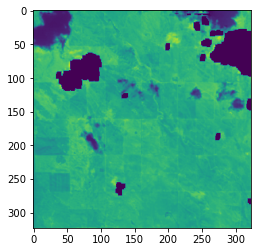

<AxesSubplot:>

In [39]:
show(shadow_img.isel(time=t).values)

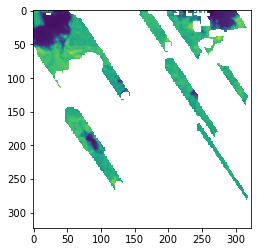

<AxesSubplot:>

In [40]:
show(shadow_img.where(mask2==0).isel(time=t).values)

In [41]:
shadow_type_p = np.logical_and(mask2 == 0, water == 0)
shadow = mask_hls(hls_ds['FMASK'], mask_types=['shadow'])
#shadow
#shadow_img.where(np.logical_and(shadow==1, shadow_type_p)).values()#.flatten()
kmeansresult_shadow = classify_shadow(surf_type='land', type_p=shadow_type_p, shadow_idx=shadow_img, mask2=mask2, water=water, shadow=shadow)

Shadow index centers of shadow, nonshadow dark and nonshadow bright on land : [ 679.91468857 2515.15194828 6085.97923875]


In [42]:
mask2 = kmeansresult_shadow[2].persist()

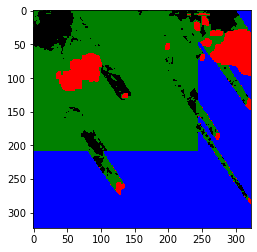

<AxesSubplot:>

In [43]:
show(mask2.isel(time=t).values, cmap=cmap_mask, norm=norm_mask)

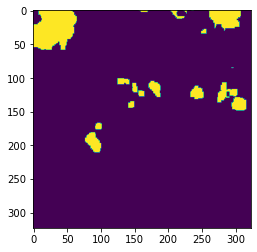

<AxesSubplot:>

In [44]:
show(shadow.isel(time=t).values)

In [45]:
from skimage.filters import threshold_li
from skimage.morphology import opening
def threshold_li_xr(shadow):
    threshold = xr.apply_ufunc(threshold_li,
                               shadow,
                               dask='parallelized',
                               vectorize=True,
                               input_core_dims=[['y', 'x']])
    return threshold

def opening_np(img):
    return opening(img)

def opening_xr(shadow_binary):        
    newbinary = xr.apply_ufunc(opening_np,
                               shadow_binary,
                               dask='parallelized',
                               vectorize=True,
                               input_core_dims=[['y', 'x']],
                               output_core_dims=[['y', 'x']],
                               output_dtypes=['int'])
    return newbinary
# get shadow threshold using Li approach
shadow_thresh = threshold_li_xr(shadow_img.where(shadow_img != 0))

In [46]:
#show(shadow_img.where(shadow_img != 0).isel(time=5).values, vmin=100, vmax=4000)
#binary = shadow_img > shadow_thresh
#show(binary.isel(time=t))
#shadow_thresh.values

In [47]:
#print("Image: " + str(ii) + ".....Threshold for shadows is:" + str(thresh))
#binary = shadow_img > shadow_thresh
#binary = xr.where(mask2 == 0, binary, 1)
#binary = opening_xr(binary)
binary = mask2 != 0
mask_shadow_ini = mask * binary

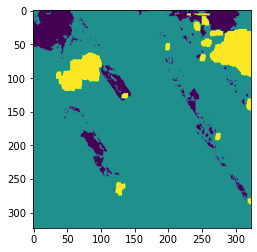

<AxesSubplot:>

In [48]:
show(mask_shadow_ini.isel(time=t).values)

In [49]:
# only use non_initial_shadow points to compute the mean and sd
ind_valid = mask_shadow_ini == 1
num_nonc = ind_valid.sum(dim=['y', 'x'])
time_nonc = (num_nonc < 2).persist()

#if num_nonc >= 2:
#    mask = mask_shadow_ini

b2_mean = shadow_img.where(ind_valid).mean()
b2_sd = shadow_img.where(ind_valid).std()
# refine initial shadow
ind_shadow = np.logical_and(shadow_img < b2_mean, mask_shadow_ini == 0)
num_shadow = ind_shadow.sum(dim=['y', 'x'])
time_shadow = (num_shadow > 0).persist()

#if num_shadow > 0:
#    mask[ind_shadow] =0

# Add shadow from non-initial window
ind_shadow2 = np.logical_and(np.logical_and(shadow_img < (b2_mean - atsa_params['B_shadow'] * b2_sd),
                                           shadow_img < atsa_params['dn_max'] * 0.5), mask2 == 0)
num_shadow2 = ind_shadow2.sum(dim=['y', 'x'])
time_shadow2 = (num_shadow2 > 0).persist()
#if num_shadow2:
#    mask[ind_shadow2] =0

    
# for edge pixels, edge pixels using less strict threshold
ind_shadow_edge = np.logical_and(np.logical_and(shadow_img < (b2_mean - (atsa_params['B_shadow'] + 1.0) * b2_sd),
                                                shadow_img < atsa_params['dn_max'] * 0.5), mask2 == 99)
num_shadow_edge = ind_shadow_edge.sum(dim=['y', 'x'])
time_shadow_edge = (num_shadow_edge > 0).persist()
#if num_shadow_edge > 0:
#    mask[ind_shadow_edge] =0
    
#xr.where()

In [50]:
#mask_old = mask.copy(deep=True)
#mask = mask_old.copy(deep=True)

In [51]:
mask = xr.where(mask.where(mask['time'].isin(mask['time'][time_nonc])).fillna(False),
                mask_shadow_ini,
                mask)

mask = xr.where(ind_shadow.where(ind_shadow['time'].isin(ind_shadow['time'][~time_nonc & time_shadow])).fillna(False),
                0,
                mask)

mask = xr.where(ind_shadow2.where(ind_shadow2['time'].isin(ind_shadow2['time'][~time_nonc & ~time_shadow & time_shadow2])).fillna(False),
                0,
                mask)

mask = xr.where(ind_shadow_edge.where(ind_shadow_edge['time'].isin(ind_shadow_edge['time'][~time_nonc & ~time_shadow & ~time_shadow2 & time_shadow_edge])).fillna(False),
                0,
                mask)

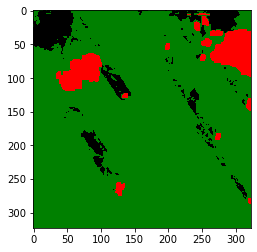

<AxesSubplot:>

In [52]:
show(mask.isel(time=t).values, cmap=cmap_mask, norm=norm_mask)

In [53]:
# correct isolated shadow
mask = remove_shadow(3, mask)

In [54]:
# buffer shadow by moving window
mask = buffer_shadow(mask, atsa_params['buffer'], 'buffer3', 0)
mask = mask.transpose('time', 'y', 'x')
mask.name = 'ATSA'
mask = mask.to_dataset()

In [55]:
mask.to_netcdf(re.sub('hls_ds_', 'hls_atsa_', nc_f))

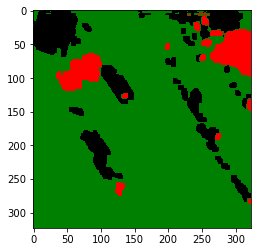

<AxesSubplot:>

In [56]:
show(mask['ATSA'].isel(time=t).values, cmap=cmap_mask, norm=norm_mask)